In [2]:
! pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.8 MB/s eta 0:00:00


## Import Library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV

from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                             roc_curve, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Loading Dataset

In [5]:
twitter_data = pd.read_csv('stock_data.csv')


In [6]:
twitter_data.shape

(5791, 2)

In [7]:
twitter_data.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [8]:
twitter_data.isnull().sum()

,0
Text,0
Sentiment,0


In [11]:
twitter_data['Sentiment'] = twitter_data['Sentiment'].replace(-1, 0)

In [12]:
# kiểm tra sự phân bố của các nhãn
# nếu các nhãn phân bố không đồng đều, phải thực hiện lấy mẫu ngẫu nhiên
twitter_data['Sentiment'].value_counts()

,count
Sentiment,
1,3685
0,2106


## Preprocessing

Gồm các công việc:
- Chuyển tất cả chữ cái thành chữ thường
- Mở rộng từ viết tắt
- Loại bỏ các url và username có trong tweet
- Loại bỏ dấu câu
- loại bỏ stopword
- Lemmatization

In [13]:
def preprocess_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)


In [14]:
text = "I can't believe this product is amazing!!! 😍 Check it out: https://example.com"
processed_text = preprocess_text(text)
print(processed_text)

believe product amazing check


In [15]:
twitter_data['clean_data'] = twitter_data['Text'].apply(preprocess_text)

In [16]:
twitter_data.head()

,Text,Sentiment,clean_data
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kicker watchlist xide tit soq pnk cpw bpz aj t...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user aap movie return fea geed indicator trade...
2,user I'd be afraid to short AMZN - they are lo...,1,user would afraid short amzn looking like near...
3,MNTA Over 12.00,1,mnta
4,OI Over 21.37,1,oi


In [17]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        5791 non-null   object
 1   Sentiment   5791 non-null   int64 
 2   clean_data  5791 non-null   object
dtypes: int64(1), object(2)
memory usage: 135.9+ KB


In [18]:
print(twitter_data['clean_data'])

0       kicker watchlist xide tit soq pnk cpw bpz aj t...
1       user aap movie return fea geed indicator trade...
2       user would afraid short amzn looking like near...
3                                                    mnta
4                                                      oi
                              ...                        
5786    industry body cii said discoms likely suffer n...
5787    gold price slip r investor book profit amid co...
5788    worker bajaj auto agreed wage cut period april...
5789    sharemarket live sensex day high point nifty t...
5790    sensex nifty climb day high still key factor d...
Name: clean_data, Length: 5791, dtype: object


In [20]:
print(twitter_data['Sentiment'])

0       1
1       1
2       1
3       1
4       1
       ..
5786    0
5787    0
5788    1
5789    1
5790    1
Name: Sentiment, Length: 5791, dtype: int64


In [21]:
X = twitter_data['clean_data'].values
Y = twitter_data['Sentiment'].values

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [23]:
#max_features=5000
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [24]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 37896 stored elements and shape (4632, 6551)>
  Coords	Values
  (0, 2627)	0.45221095065109146
  (0, 2741)	0.2534118102883308
  (0, 6215)	0.22376466058378805
  (0, 6283)	0.3288527538502497
  (0, 3888)	0.3138834915118952
  (0, 4627)	0.45221095065109146
  (0, 5526)	0.21388967753796725
  (0, 5381)	0.38603803573891693
  (0, 795)	0.274374204599553
  (1, 1229)	0.1876771520807697
  (1, 4226)	0.24585079487011605
  (1, 3056)	0.3396623782143356
  (1, 78)	0.36889214810252813
  (1, 2234)	0.26589924294019185
  (1, 2974)	0.36889214810252813
  (1, 4870)	0.36889214810252813
  (1, 1759)	0.25469463501454737
  (1, 3781)	0.3302524940802337
  (1, 1652)	0.36889214810252813
  (2, 3)	0.4333534596529686
  (2, 4720)	0.9012240448450112
  (3, 1316)	0.22777321627108918
  (3, 4111)	0.20126833232628966
  (3, 5928)	0.22777321627108918
  (3, 811)	0.1627842455088909
  :	:
  (4629, 3)	0.16539378369352314
  (4629, 2535)	0.2521750156684987
  (4629, 4465)	0.33081

In [25]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8810 stored elements and shape (1159, 6551)>
  Coords	Values
  (0, 3)	0.14153314565413672
  (0, 305)	0.2719059142770062
  (0, 1134)	0.4286397871264973
  (0, 2055)	0.336922129956658
  (0, 3105)	0.34510772213890445
  (0, 3549)	0.2760786173366959
  (0, 3678)	0.27394786194058723
  (0, 4116)	0.34510772213890445
  (0, 4663)	0.3209765452539757
  (0, 6130)	0.160090381614621
  (0, 6421)	0.30110889564938204
  (1, 3)	0.4294767110861465
  (1, 1852)	0.9030779338654149
  (2, 449)	0.2292473322218253
  (2, 1324)	0.38319837660507733
  (2, 2800)	0.41927963891218567
  (2, 3452)	0.21212026254824318
  (2, 3460)	0.24629106242904555
  (2, 3744)	0.3260109288696269
  (2, 5016)	0.40766406687652706
  (2, 5526)	0.19831361145952447
  (2, 5587)	0.4553609012192939
  (3, 3708)	0.825520805558173
  (3, 3784)	0.5643716856740644
  (4, 5526)	0.3115336598532592
  :	:
  (1155, 5526)	0.19734022204016274
  (1155, 6429)	0.5166006826777142
  (1156, 795)	0.44339484274

## Training Model

### GaussianNB

Best var_smoothing: {'var_smoothing': 1e-05}
Best CV Accuracy: 0.5947754749568221

Test Accuracy: 0.5616911130284729

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.69      0.53       421
           1       0.73      0.49      0.59       738

    accuracy                           0.56      1159
   macro avg       0.58      0.59      0.56      1159
weighted avg       0.63      0.56      0.57      1159

AUC Score: 0.5903980714391467


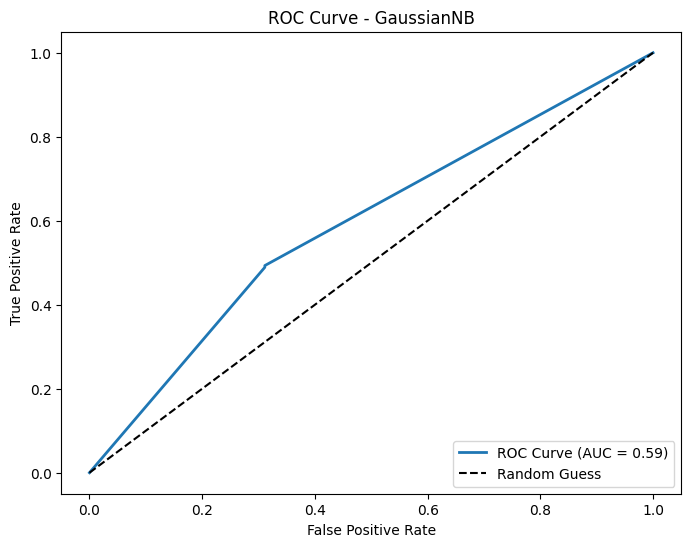

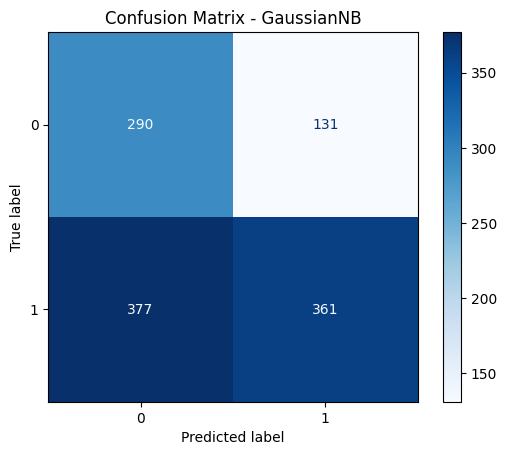

In [26]:
gnb = GaussianNB()
X_train_GB = X_train.toarray()

param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
grid_search = GridSearchCV(gnb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_GB, y_train)

print("Best var_smoothing:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

best_gnb = grid_search.best_estimator_
X_test_GB = X_test.toarray()
y_pred = best_gnb.predict(X_test_GB)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

if hasattr(best_gnb, "predict_proba"):
    y_proba = best_gnb.predict_proba(X_test_GB)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - GaussianNB")
    plt.legend(loc="lower right")
    plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GaussianNB")
plt.show()

### Bernoulli Naive Bayes

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'alpha': 0.5}
Best Cross-Validation Accuracy: 0.7387737478411053

Test Accuracy: 0.7471958584987057

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.59      0.63       421
           1       0.78      0.84      0.81       738

    accuracy                           0.75      1159
   macro avg       0.73      0.71      0.72      1159
weighted avg       0.74      0.75      0.74      1159

AUC Score: 0.8078375142421259


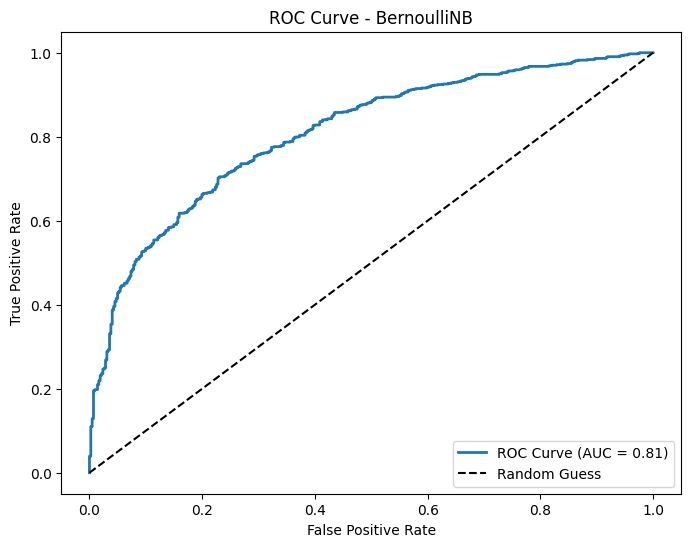

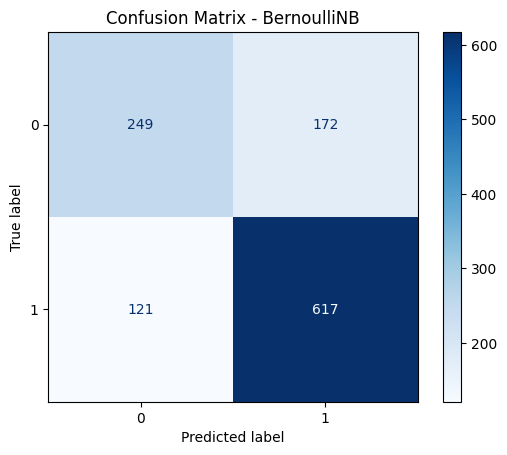

In [27]:
bnb = BernoulliNB()
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

grid_search = GridSearchCV(bnb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_bnb = grid_search.best_estimator_
y_pred = best_bnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_proba = best_bnb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BernoulliNB")
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BernoulliNB")
plt.show()

### KNN

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_neighbors': 11}
Best Cross-Validation Accuracy: 0.7141623488773748

Test Accuracy: 0.7031924072476272

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.21      0.34       421
           1       0.69      0.98      0.81       738

    accuracy                           0.70      1159
   macro avg       0.78      0.60      0.58      1159
weighted avg       0.75      0.70      0.64      1159

AUC Score: 0.8023209032565386


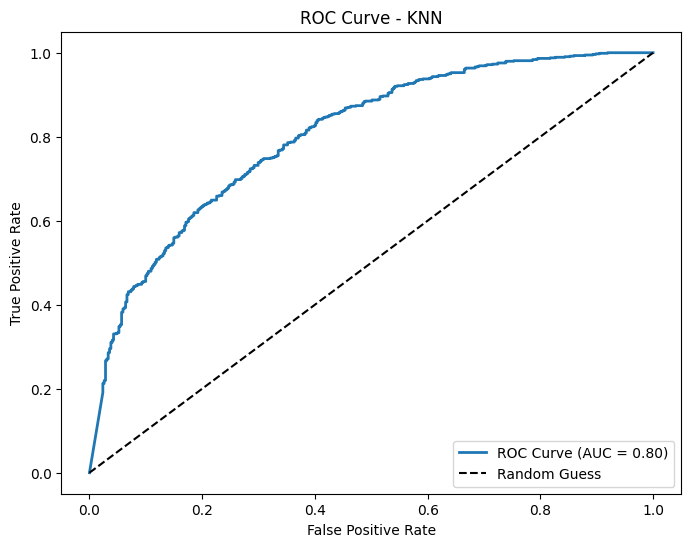

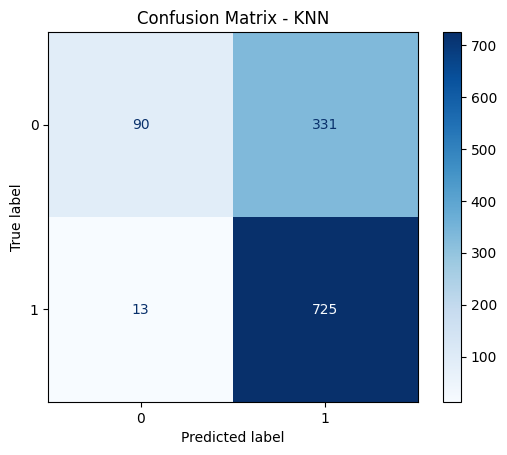

In [28]:
knn = KNeighborsClassifier(weights='distance',metric='euclidean')

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

if hasattr(best_knn, "predict_proba"):
    y_proba = best_knn.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - KNN")
    plt.legend(loc="lower right")
    plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()

### Logistic Regression

Best Parameters: {'C': 10, 'penalty': 'l2'}
Best CV Accuracy: 0.7737488962048085
Test Accuracy: 0.7670405522001725

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.62      0.66       421
           1       0.80      0.85      0.82       738

    accuracy                           0.77      1159
   macro avg       0.75      0.74      0.74      1159
weighted avg       0.76      0.77      0.76      1159

AUC Score: 0.837731494892146


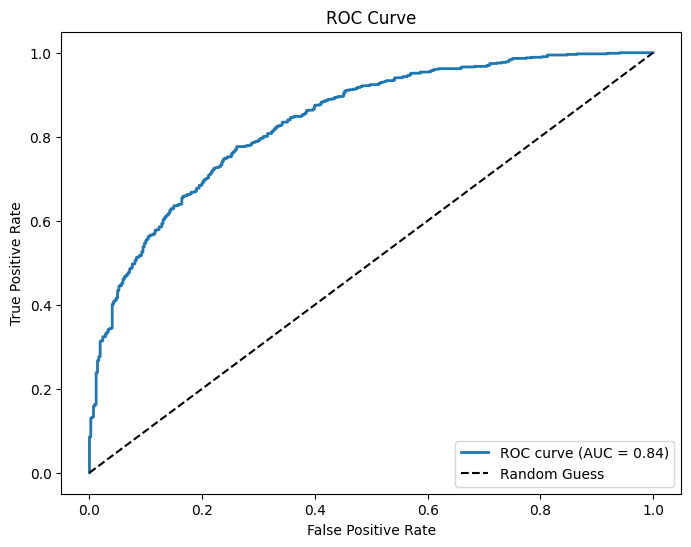

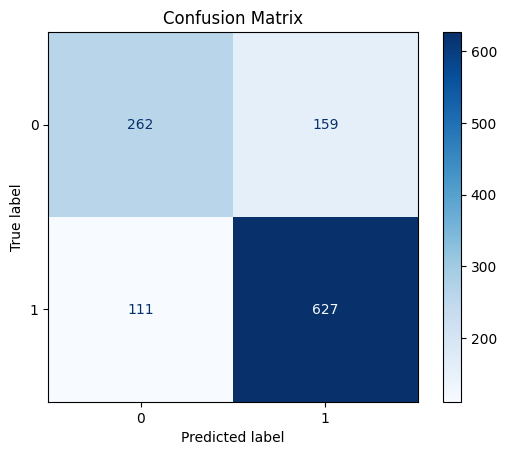

In [29]:

lr = LogisticRegression(solver='liblinear', random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_proba = grid_search.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.7733148338424188

Test Accuracy: 0.7713546160483176

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67       421
           1       0.80      0.85      0.83       738

    accuracy                           0.77      1159
   macro avg       0.75      0.74      0.75      1159
weighted avg       0.77      0.77      0.77      1159

AUC Score: 0.8342779805470264


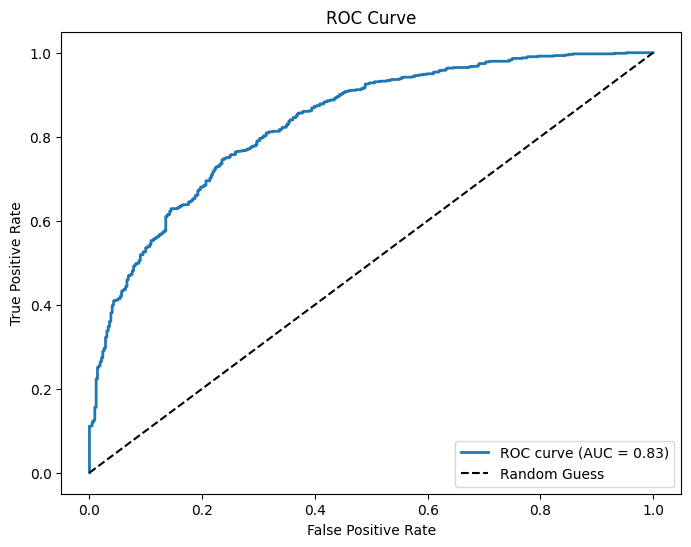

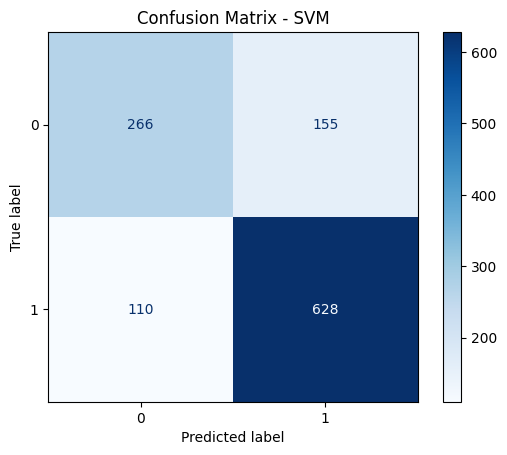

In [32]:
svm = LinearSVC(random_state=42)

param_grid = {'penalty':['l1', 'l2'],
              'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_proba = best_svm.decision_function(X_test)
auc = roc_auc_score(y_test, y_proba)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.show()

### Decision tree

Best Parameters: {'max_depth': 100, 'min_samples_split': 100}
Best Cross-Validation Accuracy: 0.7487046632124352

Test Accuracy: 0.722174288179465

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.58      0.60       421
           1       0.77      0.80      0.79       738

    accuracy                           0.72      1159
   macro avg       0.70      0.69      0.69      1159
weighted avg       0.72      0.72      0.72      1159

AUC Score: 0.7375200355328968


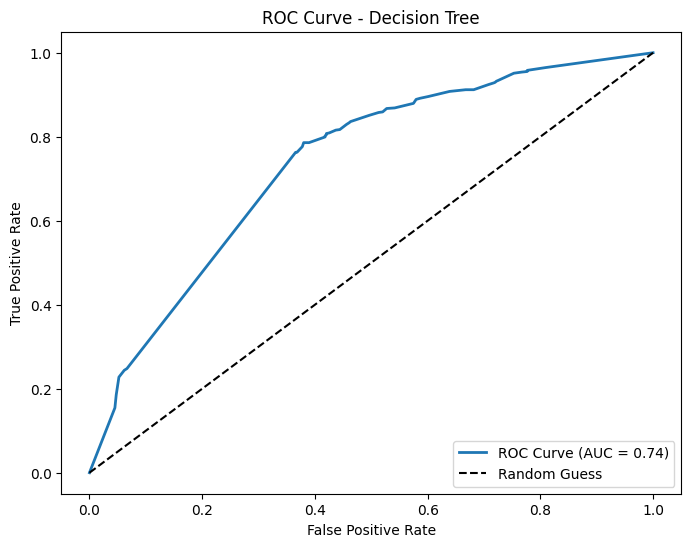

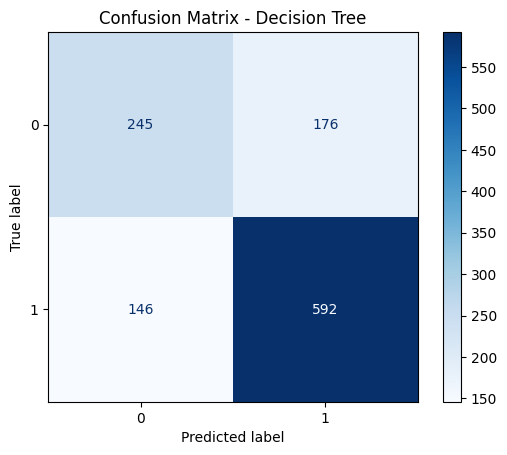

In [33]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [1, 10, 20, 50,100],
    'min_samples_split': [5, 10, 100, 500]
}

grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

if hasattr(grid_search.best_estimator_, "predict_proba"):
    y_proba = grid_search.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Decision Tree")
    plt.legend(loc="lower right")
    plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

### Random Forest

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters: {'max_depth': 120, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.7672711571675301

Test Accuracy: 0.7532355478861087

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.58      0.63       421
           1       0.78      0.85      0.81       738

    accuracy                           0.75      1159
   macro avg       0.74      0.72      0.72      1159
weighted avg       0.75      0.75      0.75      1159

AUC Score: 0.8210867144300896


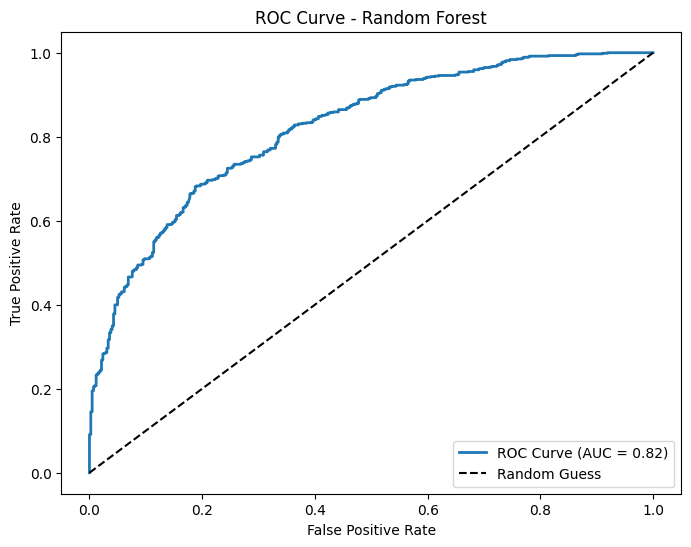

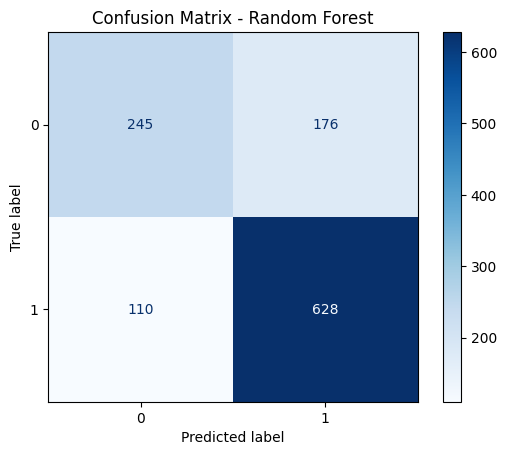

In [34]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced')

param_grid = {
    'n_estimators': [5, 50, 100,150,200],
    'max_depth': [ 5, 10, 30,50,120]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


if hasattr(best_rf, "predict_proba"):
    y_proba = best_rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest")
    plt.legend(loc="lower right")
    plt.show()

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()


### XGBoost

Fitting 3 folds for each of 35 candidates, totalling 105 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'max_depth': 5, 'n_estimators': 120}
Best CV Accuracy: 0.7577720207253886

Test Accuracy: 0.7446074201898188

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.50      0.59       421
           1       0.76      0.88      0.81       738

    accuracy                           0.74      1159
   macro avg       0.73      0.69      0.70      1159
weighted avg       0.74      0.74      0.73      1159

AUC Score: 0.8019813452291293


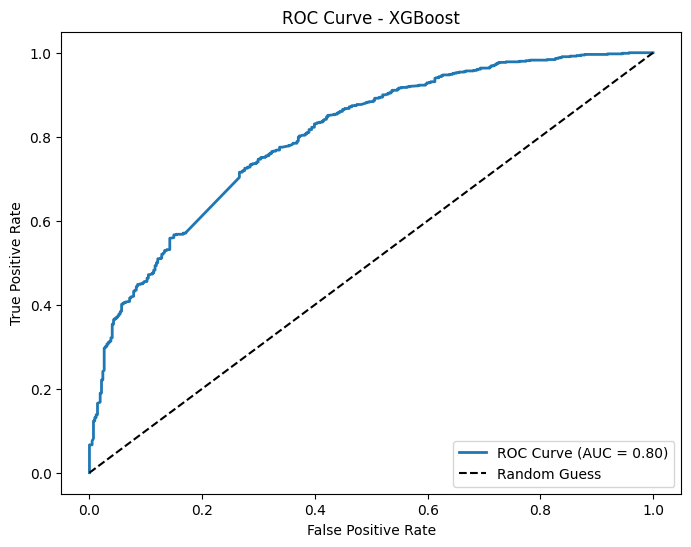

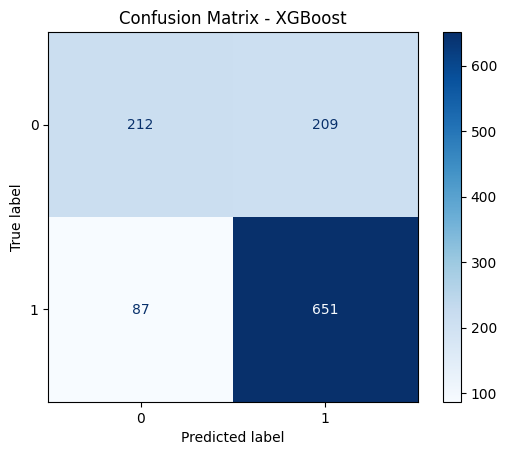

In [35]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)

# 5. Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [5, 10, 50, 100, 120],
    'max_depth': [1, 5, 7, 10, 15, 25, 30]
}

# 6. Optimize the model using GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# 7. Evaluate the optimized model on the test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate AUC (if needed) using predicted probabilities for the positive class
if hasattr(best_xgb, "predict_proba"):
    y_proba = best_xgb.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("AUC Score:", auc)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - XGBoost")
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

## Conclusion

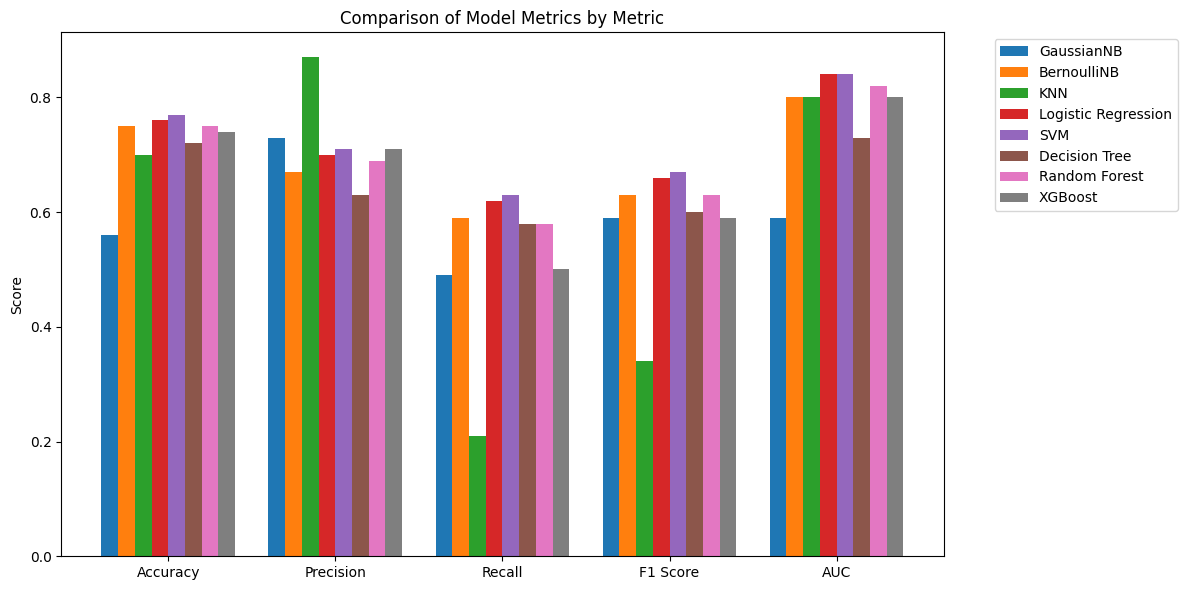

In [36]:
import matplotlib.pyplot as plt
import numpy as np
metrics = {
    'GaussianNB':            {'Accuracy': 0.56, 'Precision': 0.73, 'Recall': 0.49, 'F1 Score': 0.59, 'AUC': 0.59},
    'BernoulliNB':           {'Accuracy': 0.75, 'Precision': 0.67, 'Recall': 0.59, 'F1 Score': 0.63, 'AUC': 0.8},
    'KNN':                   {'Accuracy': 0.7, 'Precision': 0.87, 'Recall': 0.21, 'F1 Score': 0.34, 'AUC': 0.8},
    'Logistic Regression':   {'Accuracy': 0.76, 'Precision': 0.7, 'Recall': 0.62, 'F1 Score': 0.66, 'AUC': 0.84},
    'SVM':                   {'Accuracy': 0.77, 'Precision': 0.71, 'Recall': 0.63, 'F1 Score': 0.67, 'AUC': 0.84},
    'Decision Tree':         {'Accuracy': 0.72, 'Precision': 0.63, 'Recall': 0.58, 'F1 Score': 0.6, 'AUC': 0.73},
    'Random Forest':         {'Accuracy': 0.75, 'Precision': 0.69, 'Recall': 0.58, 'F1 Score': 0.63, 'AUC': 0.82},
    'XGBoost':               {'Accuracy': 0.74, 'Precision': 0.71, 'Recall': 0.50, 'F1 Score': 0.59, 'AUC': 0.8}
}

model_names = list(metrics.keys())
metric_names = list(next(iter(metrics.values())).keys())


x = np.arange(len(metric_names))
n_models = len(model_names)
width = 0.8 / n_models

fig, ax = plt.subplots(figsize=(12, 6))


for i, model in enumerate(model_names):
    offset = -0.4 + (i + 0.5) * width
    values = [metrics[model][m] for m in metric_names]
    ax.bar(x + offset, values, width, label=model)

ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Metrics by Metric')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Save model


In [37]:
import joblib
joblib.dump(best_svm, 'svm_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')



['vectorizer.pkl']

## Load and use model

In [38]:
model = joblib.load('svm_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

In [39]:
def predict_sentiment(text, model, vectorizer):
    """
    Predicts sentiment from raw text using the given model and vectorizer.

    Parameters:
      text (str or list of str): The raw input text.
      model: The trained model (e.g., a scikit-learn estimator).
      vectorizer: The fitted vectorizer used to transform raw text (e.g., TfidfVectorizer).

    Returns:
      prediction: The predicted sentiment label(s).
    """
    if isinstance(text, str):
        text = [text]

    text_features = vectorizer.transform(text)
    prediction = model.predict(text_features)

    return prediction

# Example
sample_text = "Insanity of today weirdo massive selling. $aapl bid up 45 cents after hours after non stop selling in trading hours"
predicted_label = predict_sentiment(sample_text, model, vectorizer)
print("Predicted Sentiment:", predicted_label)


Predicted Sentiment: [0]
